## Load library

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from scipy import stats
from scipy.signal import find_peaks

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(1)

Using TensorFlow backend.


In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

In [93]:
from pickle import dump

## Data preprocessing

In [2]:
data = pd.read_csv('creditcard.csv')
data = data.drop(columns=['Time'])
# data = data.sample(frac = 0.1 ,random_state=1)
print(data.isnull().values.any())

data

False


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [3]:
data["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [4]:
data_scale = preprocessing.MinMaxScaler().fit_transform(data.values)
y = data["Class"].values
X_normal, X_fraud = data_scale[y == 0], data_scale[y == 1]
Y_normal, Y_fraud = np.zeros(X_normal.shape[0]), np.ones(X_fraud.shape[0])

In [5]:
outlier_fraction = len(Y_fraud)/float(len(Y_normal))
print(outlier_fraction)
print("Fraud Cases : {}".format(len(Y_fraud)))
print("Valid Cases : {}".format(len(Y_normal)))

0.0017304750013189597
Fraud Cases : 492
Valid Cases : 284315


In [6]:
# X_train_all, X_test_all, Y_train_all, Y_test_all = train_test_split(data_scale, y, test_size=0.2)

X_train_normal, X_test_normal, Y_train_normal, Y_test_normal = train_test_split(X_normal, Y_normal, test_size=0.2)
X_train_fraud, X_test_fraud, Y_train_fraud, Y_test_fraud = train_test_split(X_fraud, Y_fraud, test_size=0.2)

X_train_all = np.append(X_train_normal, X_train_fraud, axis = 0)
X_test_all = np.append(X_test_normal, X_test_fraud, axis = 0)
Y_train_all = np.append(Y_train_normal, Y_train_fraud)
Y_test_all = np.append(Y_test_normal, Y_test_fraud)

# all fraud with test normal
X_test_afwn = np.append(X_test_normal, X_fraud, axis = 0)
Y_test_afwn = np.append(Y_test_normal, Y_fraud)

## Isolation forest (unsupervised)

In [118]:
# clf = IsolationForest(contamination=outlier_fraction)
# clf.fit(X_train_all)

In [119]:
param_grid = {'n_estimators': [100, 150, 200],
            'max_samples': ['auto', 100],
            'contamination': [outlier_fraction, 'auto']}

f1_ms = make_scorer(f1_score, average='macro')

clf_if = IsolationForest()
clf_if = GridSearchCV(clf_if, param_grid, scoring=f1_ms, verbose=100)

clf_if.fit(X_train_all, Y_train_all)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] contamination=0.0017304750013189597, max_samples=auto, n_estimators=100 
[CV]  contamination=0.0017304750013189597, max_samples=auto, n_estimators=100, score=0.000, total=  24.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.0s remaining:    0.0s
[CV] contamination=0.0017304750013189597, max_samples=auto, n_estimators=100 
[CV]  contamination=0.0017304750013189597, max_samples=auto, n_estimators=100, score=0.000, total=  24.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.1s remaining:    0.0s
[CV] contamination=0.0017304750013189597, max_samples=auto, n_estimators=100 
[CV]  contamination=0.0017304750013189597, max_samples=auto, n_estimators=100, score=0.000, total=  24.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[CV] contamination=0.0017304750013189597, max_samples=auto, n_esti

[CV]  contamination=auto, max_samples=auto, n_estimators=100, score=0.000, total=  14.2s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 18.5min remaining:    0.0s
[CV] contamination=auto, max_samples=auto, n_estimators=100 ..........
[CV]  contamination=auto, max_samples=auto, n_estimators=100, score=0.000, total=  12.8s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed: 18.7min remaining:    0.0s
[CV] contamination=auto, max_samples=auto, n_estimators=100 ..........
[CV]  contamination=auto, max_samples=auto, n_estimators=100, score=0.000, total=  14.1s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed: 19.0min remaining:    0.0s
[CV] contamination=auto, max_samples=auto, n_estimators=100 ..........
[CV]  contamination=auto, max_samples=auto, n_estimators=100, score=0.001, total=  13.2s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed: 19.2min remaining:    0.0s
[CV] contamination=auto, max_samples=auto, n_estimators=150 ..........
[CV]  contamination=auto, max_samples=au

GridSearchCV(cv=None, error_score=nan,
             estimator=IsolationForest(behaviour='deprecated', bootstrap=False,
                                       contamination='auto', max_features=1.0,
                                       max_samples='auto', n_estimators=100,
                                       n_jobs=None, random_state=None,
                                       verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'contamination': [0.0017304750013189597, 'auto'],
                         'max_samples': ['auto', 100],
                         'n_estimators': [100, 150, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score, average=macro), verbose=100)

In [120]:
clf_if.best_params_

{'contamination': 0.0017304750013189597,
 'max_samples': 100,
 'n_estimators': 200}

In [121]:
y_pred = clf_if.predict(X_test_all)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
print(classification_report(Y_test_all,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       0.26      0.24      0.25        99

    accuracy                           1.00     56962
   macro avg       0.63      0.62      0.62     56962
weighted avg       1.00      1.00      1.00     56962



In [159]:
dump(clf_if.best_estimator_, open('isolation_forest.pkl', 'wb'))

## Random forest (supervised)

In [151]:
param_grid = {'n_estimators': [100, 150, 200],
              'criterion': ['gini', 'entropy'],
             'min_samples_split': [2, 5]}

In [152]:
clf_rf = RandomForestClassifier()
clf_rf = GridSearchCV(clf_rf, param_grid, scoring=f1_ms, verbose=100)
clf_rf.fit(X_train_all, Y_train_all)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] criterion=gini, min_samples_split=2, n_estimators=100 ...........
[CV]  criterion=gini, min_samples_split=2, n_estimators=100, score=1.000, total= 1.2min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[CV] criterion=gini, min_samples_split=2, n_estimators=100 ...........
[CV]  criterion=gini, min_samples_split=2, n_estimators=100, score=1.000, total= 1.2min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s
[CV] criterion=gini, min_samples_split=2, n_estimators=100 ...........
[CV]  criterion=gini, min_samples_split=2, n_estimators=100, score=1.000, total= 1.3min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.7min remaining:    0.0s
[CV] criterion=gini, min_samples_split=2, n_estimators=100 ...........
[CV]  criterion=gini, min_samples_split=2, n_estimators=100, score=1.0

[CV]  criterion=entropy, min_samples_split=2, n_estimators=100, score=1.000, total= 1.4min
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed: 62.1min remaining:    0.0s
[CV] criterion=entropy, min_samples_split=2, n_estimators=150 ........
[CV]  criterion=entropy, min_samples_split=2, n_estimators=150, score=1.000, total= 1.9min
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 64.0min remaining:    0.0s
[CV] criterion=entropy, min_samples_split=2, n_estimators=150 ........
[CV]  criterion=entropy, min_samples_split=2, n_estimators=150, score=1.000, total= 2.0min
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed: 66.1min remaining:    0.0s
[CV] criterion=entropy, min_samples_split=2, n_estimators=150 ........
[CV]  criterion=entropy, min_samples_split=2, n_estimators=150, score=1.000, total= 2.4min
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed: 68.4min remaining:    0.0s
[CV] criterion=entropy, min_samples_split=2, n_estimators=150 ........
[CV]  criterion=entropy, min_sam

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [153]:
clf_rf.best_params_

{'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 100}

In [154]:
y_pred = clf_rf.predict(X_test_all)
print(classification_report(Y_test_all,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       1.00      1.00      1.00        99

    accuracy                           1.00     56962
   macro avg       1.00      1.00      1.00     56962
weighted avg       1.00      1.00      1.00     56962



In [161]:
dump(clf_rf.best_estimator_, open('random_forest.pkl', 'wb'))

## One-class SVM (semi-supervised)

In [129]:
param_grid = {'kernel': ['rbf'],
             'gamma': ['scale', 0.01, 0.1, 1],
             'nu': [0.1, 0.5, 1]}

In [130]:
clf_svm = OneClassSVM()
clf_svm = GridSearchCV(clf_svm, param_grid, scoring=f1_ms, verbose=100)
clf_svm.fit(X_train_normal[:50000], Y_train_normal[:50000])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] gamma=scale, kernel=rbf, nu=0.1 .................................
[CV] ..... gamma=scale, kernel=rbf, nu=0.1, score=0.000, total=  32.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.0s remaining:    0.0s
[CV] gamma=scale, kernel=rbf, nu=0.1 .................................
[CV] ..... gamma=scale, kernel=rbf, nu=0.1, score=0.000, total=  31.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[CV] gamma=scale, kernel=rbf, nu=0.1 .................................
[CV] ..... gamma=scale, kernel=rbf, nu=0.1, score=0.000, total=  31.2s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s
[CV] gamma=scale, kernel=rbf, nu=0.1 .................................
[CV] ..... gamma=scale, kernel=rbf, nu=0.1, score=0.000, total=  31.4s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapse

[CV] ....... gamma=0.1, kernel=rbf, nu=0.5, score=0.000, total= 2.3min
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed: 53.7min remaining:    0.0s
[CV] gamma=0.1, kernel=rbf, nu=0.5 ...................................
[CV] ....... gamma=0.1, kernel=rbf, nu=0.5, score=0.000, total= 2.2min
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed: 55.9min remaining:    0.0s
[CV] gamma=0.1, kernel=rbf, nu=0.5 ...................................
[CV] ....... gamma=0.1, kernel=rbf, nu=0.5, score=0.000, total= 2.2min
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed: 58.1min remaining:    0.0s
[CV] gamma=0.1, kernel=rbf, nu=0.5 ...................................
[CV] ....... gamma=0.1, kernel=rbf, nu=0.5, score=0.000, total= 2.3min
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 60.4min remaining:    0.0s
[CV] gamma=0.1, kernel=rbf, nu=1 .....................................
[CV] ......... gamma=0.1, kernel=rbf, nu=1, score=0.000, total= 1.9min
[Parallel(n_jobs=1)]: Done  41 out of  41

GridSearchCV(cv=None, error_score=nan,
             estimator=OneClassSVM(cache_size=200, coef0=0.0, degree=3,
                                   gamma='scale', kernel='rbf', max_iter=-1,
                                   nu=0.5, shrinking=True, tol=0.001,
                                   verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'gamma': ['scale', 0.01, 0.1, 1], 'kernel': ['rbf'],
                         'nu': [0.1, 0.5, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score, average=macro), verbose=100)

In [131]:
clf_svm.best_params_

{'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.1}

In [132]:
y_pred = clf_svm.predict(X_test_all)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
print(classification_report(Y_test_all,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95     56863
         1.0       0.02      1.00      0.03        99

    accuracy                           0.90     56962
   macro avg       0.51      0.95      0.49     56962
weighted avg       1.00      0.90      0.95     56962



In [162]:
dump(clf_svm.best_estimator_, open('oneclass_svm.pkl', 'wb'))

## One-class Autoencoder
1. Semi-supervised: using threshold
1. Hybrid (semi-supervised & supervised): encoder + classifier

In [15]:
input_layer = Input(shape=(X_train_normal.shape[1],))

## encoding part
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

## decoding part
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)

## output layer
output_layer = Dense(X_train_normal.shape[1], activation='relu')(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adam", loss="mse")

In [148]:
input_layer = Input(shape=(X_train_normal.shape[1],))

## encoding part
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

## decoding part
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)

## output layer
output_layer = Dense(X_train_normal.shape[1], activation='relu')(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adam", loss="mse")

In [135]:
autoencoder.fit(X_train_normal, X_train_normal, epochs=10, shuffle=True)

Epoch 1/10
227452/227452 [==============================] - 13s 57us/step - loss: 0.0914
Epoch 2/10
227452/227452 [==============================] - 12s 51us/step - loss: 0.0334
Epoch 3/10
227452/227452 [==============================] - 12s 52us/step - loss: 0.0309
Epoch 4/10
227452/227452 [==============================] - 12s 52us/step - loss: 0.0308
Epoch 5/10
227452/227452 [==============================] - 12s 52us/step - loss: 0.0308
Epoch 6/10
227452/227452 [==============================] - 12s 53us/step - loss: 0.0282
Epoch 7/10
227452/227452 [==============================] - 12s 52us/step - loss: 9.0409e-05
Epoch 8/10
227452/227452 [==============================] - 12s 52us/step - loss: 7.2866e-05
Epoch 9/10
227452/227452 [==============================] - 12s 52us/step - loss: 6.5526e-05
Epoch 10/10
227452/227452 [==============================] - 12s 52us/step - loss: 6.1785e-05


In [136]:
def d2_visualize(x1, y1, name="graph.png", method="pca"):
    tsne = TSNE(n_components=2, random_state=1)
    pca = PCA(n_components=2, random_state=1)
    
    
    if method == "tsne":
        X_t = tsne.fit_transform(x1)
    elif method == "pca":
        X_t = pca.fit_transform(x1)
    
    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    

In [137]:
encoder = Sequential()
encoder.add(autoencoder.layers[0])
encoder.add(autoencoder.layers[1])
encoder.add(autoencoder.layers[2])

train_all_rep = encoder.predict(X_train_all)
test_all_rep = encoder.predict(X_test_all)
test_afwn_rep = encoder.predict(X_test_afwn)

In [138]:
# tsne_plot(test_afwn_rep, Y_test_afwn, "latent_representation.png")

In [139]:
clf = LogisticRegression().fit(train_all_rep, Y_train_all)
pred_y = clf.predict(test_all_rep)
print (classification_report(Y_test_all, pred_y))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       1.00      0.92      0.96        99

    accuracy                           1.00     56962
   macro avg       1.00      0.96      0.98     56962
weighted avg       1.00      1.00      1.00     56962



In [140]:
pred = autoencoder.predict(X_test_afwn)
mse = np.mean(np.power(X_test_afwn - pred, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': Y_test_afwn})

# pred = autoencoder.predict(X_test_afwn)
# mse = mean_squared_error(X_test_afwn, pred)
# error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': Y_test_afwn})

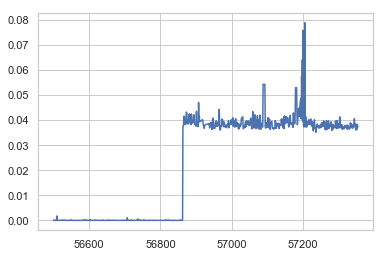

In [141]:
error_df.iloc[56500:,0].plot()

In [142]:
true_error = error_df[error_df['true_class']==0]
sorted_error = sorted(true_error['reconstruction_error'].values, reverse=True)
peaks = sorted_error[:20]
# peak_id, _ = find_peaks(true_error)
# peak_error = []
# for i in peak_id:
#     peak_error.append(true_error[i])

In [143]:
threshold_fixed = sorted_error[0] # np.mean(peaks)
threshold_fixed

0.013200526495268455

In [144]:
pred_y = [1 if e >= threshold_fixed else 0 for e in error_df.reconstruction_error.values]
print(classification_report(error_df.true_class, pred_y))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       1.00      1.00      1.00       492

    accuracy                           1.00     57355
   macro avg       1.00      1.00      1.00     57355
weighted avg       1.00      1.00      1.00     57355

